In [1]:
"""
This block loads packages
"""
import zfit # Fitting library
import hist # Histogram library

# Plotting
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)

# Numerical array calculations
import numpy as np

/work/submit/anbeck/miniforge3/envs/tutorialsIAP/lib/python3.12/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
def plot_residuals(histogram, pdf, axis):
    # Step 1: create binned pdf
    binning = zfit.binned.RegularBinning(len(histogram.values()), 70, 110, name="mass")
    mass_binned = zfit.Space("mass", binning=binning)
    pdf_binned = pdf.to_binned(mass_binned)
    # Step 2: calculate (histogram value - binned pdf value) / histogram uncertainty
    x = histogram.axes[0].centers
    Hunc = np.sqrt(np.where(histogram.variances()==0, np.ones(len(histogram.variances())), histogram.variances())) / histogram.sum()
    residual = (histogram.density() - pdf_binned.pdf(x))/Hunc
    # Step 3: plot residuals
    for i in range(0, len(x)):
        axis.fill_between([histogram.axes[0].edges[i],histogram.axes[0].edges[i+1]], [residual[i]]*2, color='k')

# Parameter estimation

## "Naive" estimate of Gaussian parameters
Imagine you want to study the mass of a particle. In previous exercises, you have seen that you can calculate the mass of the $Z^0$ boson by looking the decay $Z^0\to\mu^+\mu^-$ and taking the invariant mass of the two muons. Because of physical and experimental reasons, this mass is slightly different for each muon pair you look at. In order to measure the value of the $Z^0$ mass, you could look at 1000 $Z^0\to\mu^+\mu^-$ decays and take the average mass you get.

In [3]:
"""
This defines the two parameters for the Gaussian distribution and a variable where the Gauss is defined.
"""
true_Zmass = 91 #GeV
true_Zwidth = 2.5 #GeV
Zmass = zfit.Parameter('Zmass', true_Zmass, 0, 200, floating=True)
Zwidth = zfit.Parameter('Zwidth', true_Zwidth, 0, 10, floating=True)
mass = zfit.Space('mass', (70, 110))
mass_distribution = zfit.pdf.Gauss(Zmass, Zwidth, mass)

(0.0, 261.75050336544547)

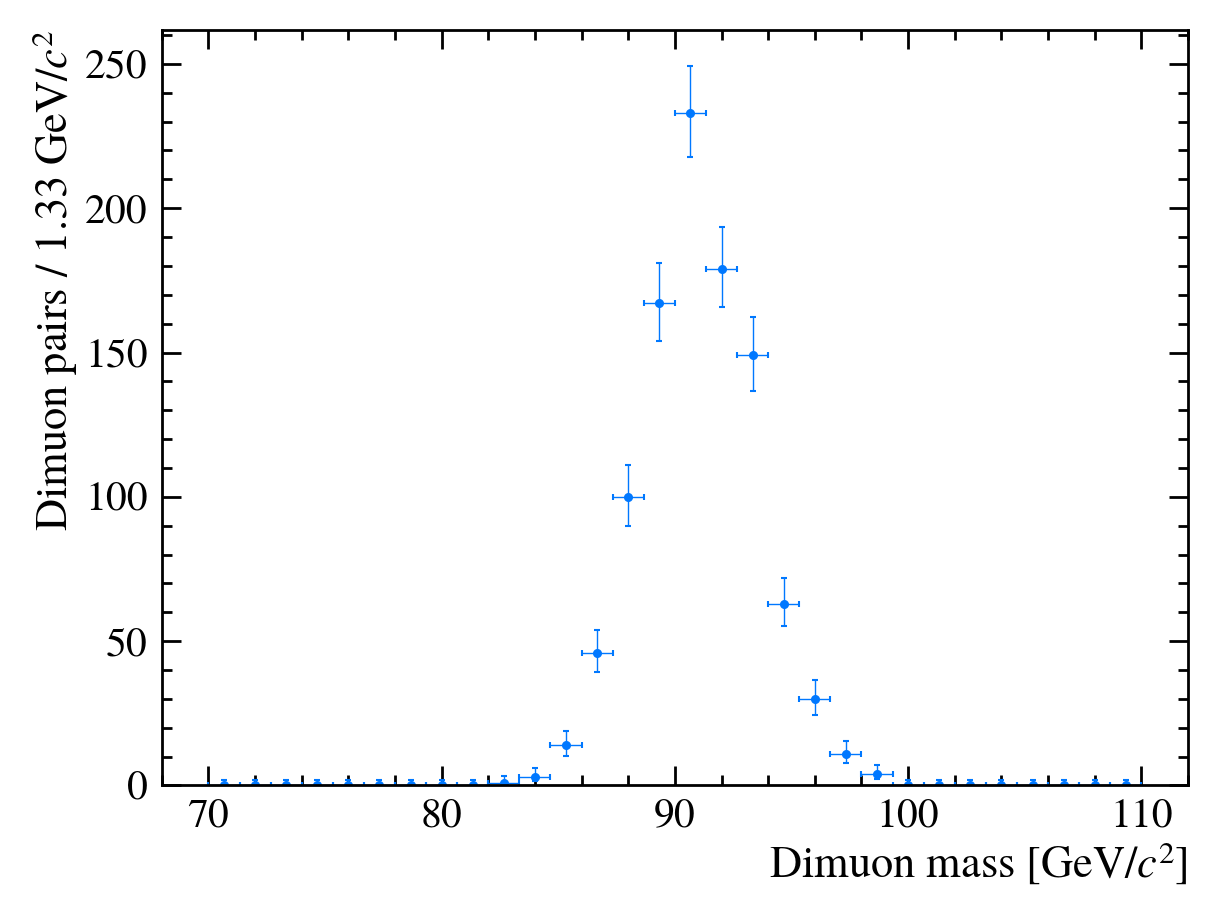

In [4]:
"""
This block generates 1000 data points from the distribution and plots them as a histogram.
"""
n_data = 1000
data = mass_distribution.sample(n=n_data)

H = hist.Hist(hist.axis.Regular(30, 70, 110))
H.fill(data["mass"])

mplhep.histplot(H, histtype="errorbar", xerr=True)
plt.xlabel(r'Dimuon mass [GeV/$c^2$]')
plt.ylabel(rf'Dimuon pairs / {(110-70)/30:.2f} GeV/$c^2$')
plt.ylim(0,)

In [5]:
np.mean(data["mass"])

91.05154226433613

If the distribution of the mass is symmetric, the average is an **unbiased estimator** for the mass and gives a useful result. This is a very special case. If the distributions are more complicated, estimation like this are not as easy anymore or produce useless results (a definition of "useful" follows later). A much more general approach to measuring parameters is fitting.

## Fitting

A very common way to estimate the best value for the parameters $\mu$ and $\sigma$ is to maximize their likelihood:
$$
\mathcal{L}(\mu, \sigma) = \prod_{\text{data points }x_i} \text{pdf}(x_i;\mu, \sigma)
$$
The likelihood is a function of the parameters and looks different for every data set! The best set of parameters maximises the likelihood. A way to think of this: good paramters make the pdf large where we have a lot of data points and small where we have few data points. As a result, there are many large factors and only few small factors in the product.

Most algorithms minimize the negative logarithm of the likelihood (NLL). The internet gives all sorts of reasons why this is (historic, mathematically more convenient, computationally more convenient, ...?).

In [6]:
# The negative logarithm of the likelihood
nll = zfit.loss.UnbinnedNLL(model=mass_distribution, data=data)

# The algorithm to minimize the nll
minimizer = zfit.minimize.Minuit()

In [7]:
# Fitting time!
result = minimizer.minimize(nll)
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[Zmass, Zwidth]] data=[<zfit.Data: Data obs=('mass',) shape=(1000, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.8e-06 │          2323.69 |  9999.655 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
Zmass              91.0516       False
Zwidth             2.47121       False


And it gives very similar values to just calculating the average (and the standard deviation)!

In [8]:
print(f"mu={np.mean(data.numpy()):.3f}, sigma={np.std(data.numpy()):.3f}")

mu=91.052, sigma=2.471


/work/submit/anbeck/miniforge3/envs/tutorialsIAP/lib/python3.12/site-packages/zfit/core/binnedpdf.py:329: UserWarning: Flow currently not fully supported. Values outside the edges are all 0.
  binindices = unbinned_to_binindex(x, self.space, flow=True)


(-2.0, 2.0)

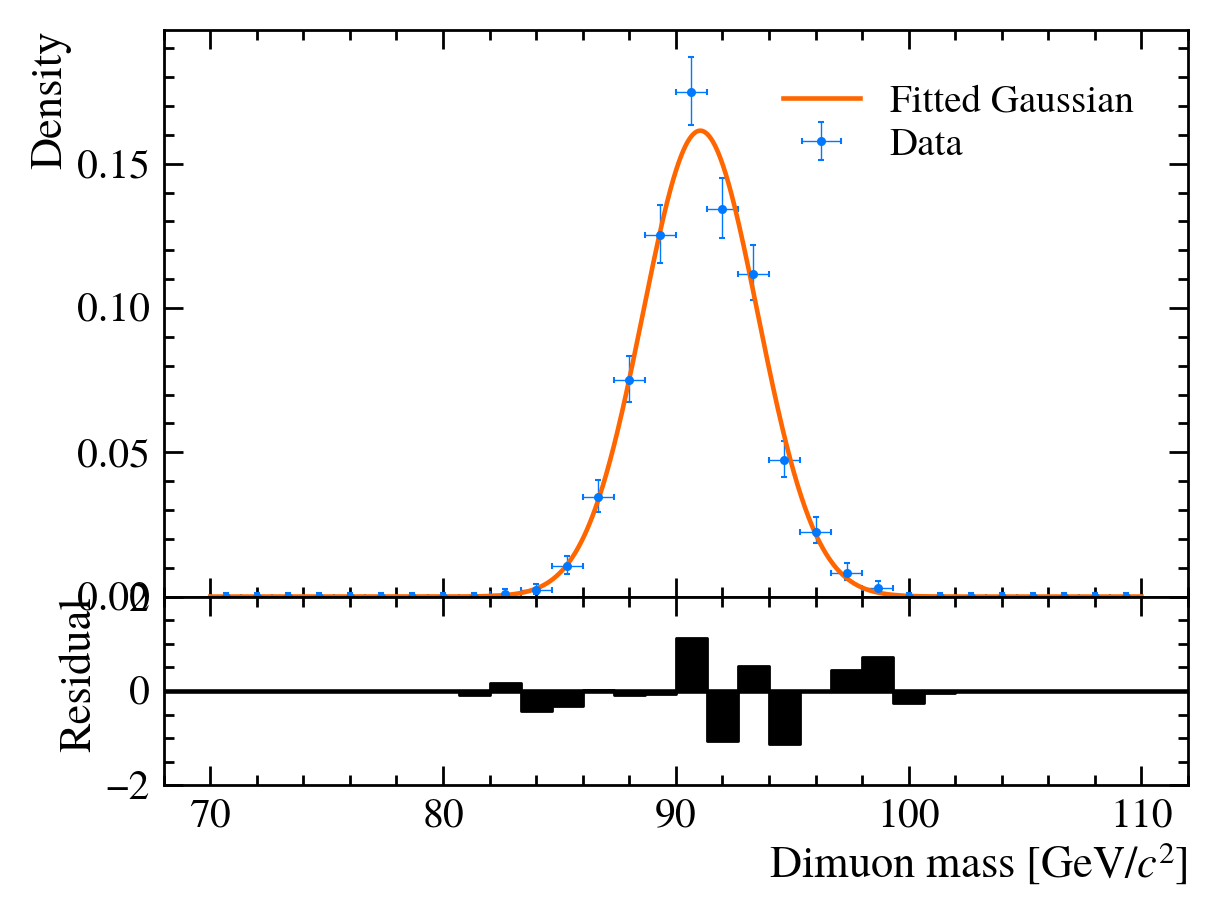

In [9]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace':0}, sharex=True)
mplhep.histplot(H, histtype="errorbar", xerr=True, density=True, label='Data', ax=a0) # Normalize histogram because this is a pdf
x = np.linspace(70,110,1000)
y = mass_distribution.pdf(x).numpy()
a0.plot(x,y,label='Fitted Gaussian')
a0.set_ylim(0,)
a0.set_ylabel('Density')
a0.legend()

plot_residuals(H, mass_distribution, a1)
a1.axhline(y=0, color='k')
a1.set_xlabel(r'Dimuon mass [GeV/$c^2$]')
a1.set_ylabel(r'Residual')
a1.set_ylim(-2,2)

The residuals are plotted for diagnostic purposes. The residual is the deviation of the model from the histogram in units of the histogram uncertainty. Here, the residuals are randomly positive or negative as expected for statistical fluctuations. We'll see an example of how this is useful later.

## Uncertainties

The uncertainty on a measured value is at least as important as the value itself. We typically assume that the measured (ie. estimated!) value follows a Gaussian distribution and the value and uncertainty we give are the mean and width of that distribution. Most statistical rules you know and we use are based on this convention. For example the classical errorpropagation assumes "Gaussian" uncertainties.

The uncertainty can be estimated using the likelihood function. The fastest and most naive way is to calculate the uncertainties from the Hesse matrix. This is a good approximation for cases that are close to ideal. some cases you will consider in your projects are far from ideal and require more advanced methods. Because this is no statitics lecture, we'll go with the basics for now though.

In [10]:
result.hesse()

{<zfit.Parameter 'Zmass' floating=True value=91.05>: {'error': 0.07814649261967917,
  'cl': 0.68268949},
 <zfit.Parameter 'Zwidth' floating=True value=2.471>: {'error': 0.05525476656273619,
  'cl': 0.68268949}}

## Validation of results

We spend most of our time making sure what we do is correct so that our results are reliable. When fitting, this means that we need to make sure that the parameter value is unbiased and the uncertainty is neither over- nor underestimated. We do this using a toy study where we generate 100 toy data sets and fit each of them.

In [11]:
n_toys = 100
results = {
    'Zmass' : np.zeros(n_toys)*np.nan,
    'Zmass_err' : np.zeros(n_toys)*np.nan,
    'Zwidth' : np.zeros(n_toys)*np.nan,
    'Zwidth_err' : np.zeros(n_toys)*np.nan
}
Zmass.set_value(true_Zmass)
Zwidth.set_value(true_Zwidth)

toydata = mass_distribution.create_sampler(n=n_data)
nll = zfit.loss.UnbinnedNLL(model=mass_distribution, data=toydata)

for i in range(0,n_toys):
    if i%int(n_toys/10)==0: print(f"{i}/{n_toys}")
    toydata.resample() # create a new random toy data set from the true distribution
    result = minimizer.minimize(nll) # fit the Gauss to the new toy
    result.hesse() # calculate the errors

    # save the values and errors
    results['Zmass'][i] = result.params[Zmass]['value']
    results['Zmass_err'][i] = result.params[Zmass]['hesse']['error']
    results['Zwidth'][i] = result.params[Zwidth]['value']
    results['Zwidth_err'][i] = result.params[Zwidth]['hesse']['error']

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


The pull of a parameter is the ratio of the difference between the true (ie. generated) value and the fitted (ie. estimated) value divided by its uncertainty:
$$
\text{pull}_a = \frac{a_\text{estimate} - a_\text{generate}}{\sigma_a}
$$

In [12]:
pull_Zmass = (results['Zmass'] - true_Zmass) / results['Zmass_err']

Remember that we never measure the true value of a parameter. We only estimate it based on a sample. This means that each of the toy fits will get a different value, uncertainty, and pull value.

Our results are only good if the pulls are distributed like a normal Gaussian (mean at zero, width of one). This means that the analysis method we use produces an unbiased estimate of the paramter and a Gaussian uncertainty. **If this is not true, we need to understand why and edit the analysis method accordingly!**

(0.0, 0.6287002606306994)

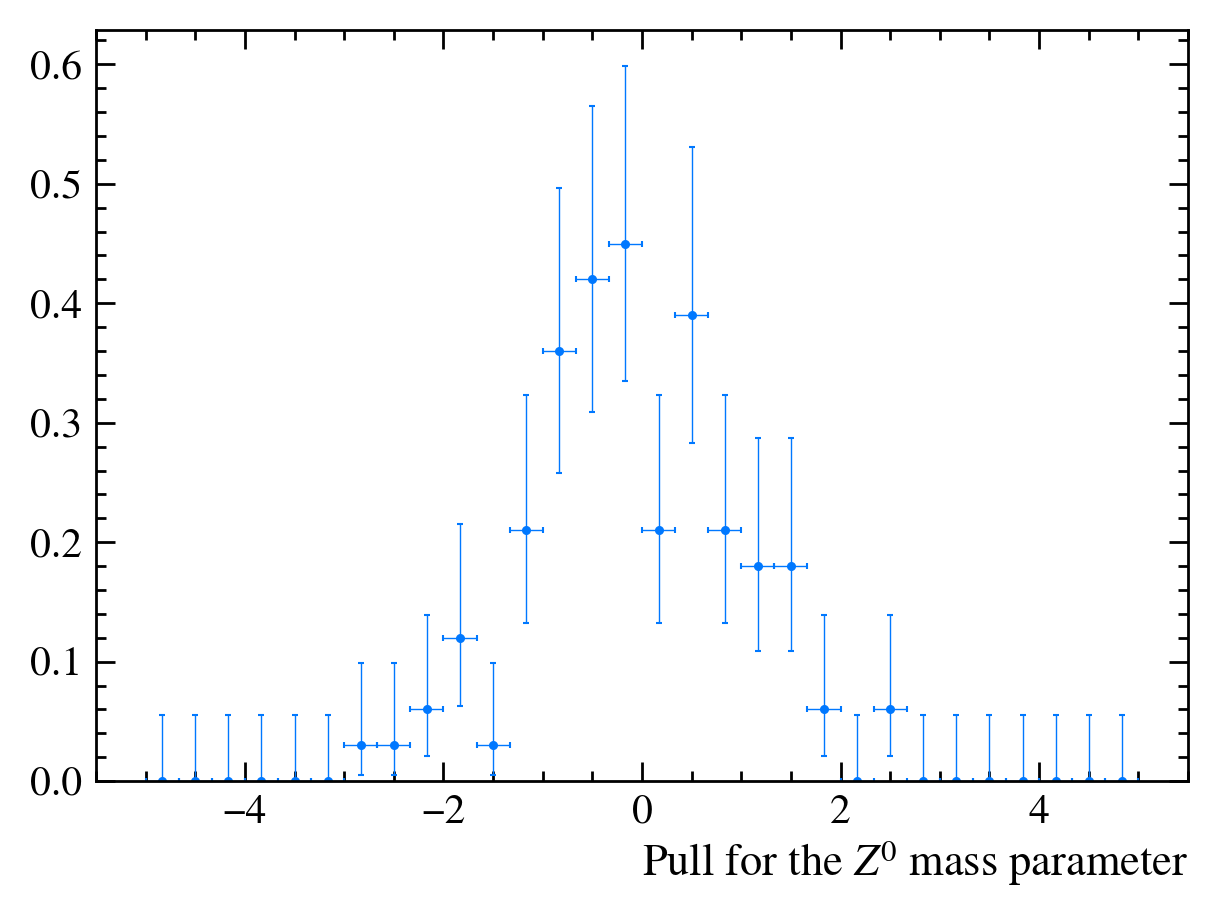

In [13]:
# A histogram of the pulls for the mean
H_pull_Zmass = hist.Hist(hist.axis.Regular(30, -5, 5))
H_pull_Zmass.fill(pull_Zmass)

mplhep.histplot(H_pull_Zmass, histtype="errorbar", xerr=True, density=True)
plt.xlabel(r'Pull for the $Z^0$ mass parameter')
plt.ylim(0,)

Looking at plots is useful but let's fit a Gauss to this distribution to make sure it is normal.
(Sorry for the inception vibes. It will get clearer with a more complex example later)

In [14]:
# Create a pdf for the pulls
mu_pulls = zfit.Parameter('mu_pull', 0, -5, 5)
sig_pulls = zfit.Parameter('sig_pull', 1, 0, 10)
pulls = zfit.Space('pulls', (-5, 5))
gauss_pulls = zfit.pdf.Gauss(mu_pulls, sig_pulls, pulls)

# Create the nll for the fit to the pulls of the Zmass parameter
nll_pull_Zmass = zfit.loss.UnbinnedNLL(model=gauss_pulls, data=pull_Zmass)
fit_pull_Zmass = minimizer.minimize(nll_pull_Zmass)
fit_pull_Zmass.hesse()
print(fit_pull_Zmass)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu_pull, sig_pull]] data=[<zfit.Data: Data obs=('pulls',) shape=(100, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00038 │           146.90 |  9999.437 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name        value  (rounded)        hesse    at limit
--------  ------------------  -----------  ----------
mu_pull           -0.0779529  +/-     0.1       False
sig_pull             1.04932  +/-   0.074       False


Awesome! The mean and width are compatible with 0 and 1 within their uncertainties. Our fit produces "useful" results.

Note that in this specific example, the average and the standard error on the mean would produce unbiased results too.

## Pathological results

Let's now consider a more realistic case. We never know the true distribution. All we ever do is model what we see using theoretical or heuristic assumptions.

For many measurements, we use muons because they leave a very nice and clean signature in the detector. However, we could use electrons to calculate the $Z^0$ mass instead! In the Standard Model, electrons and muons behave in exactly the same way, so the $Z^0$ decay to two electrons does not differ too much from the decay to two muons.

However one major experimental difference between the two decays is that electrons loose a significant amount of energy due to Bremsstrahlung. This skews the mass distribution towards lower masses.

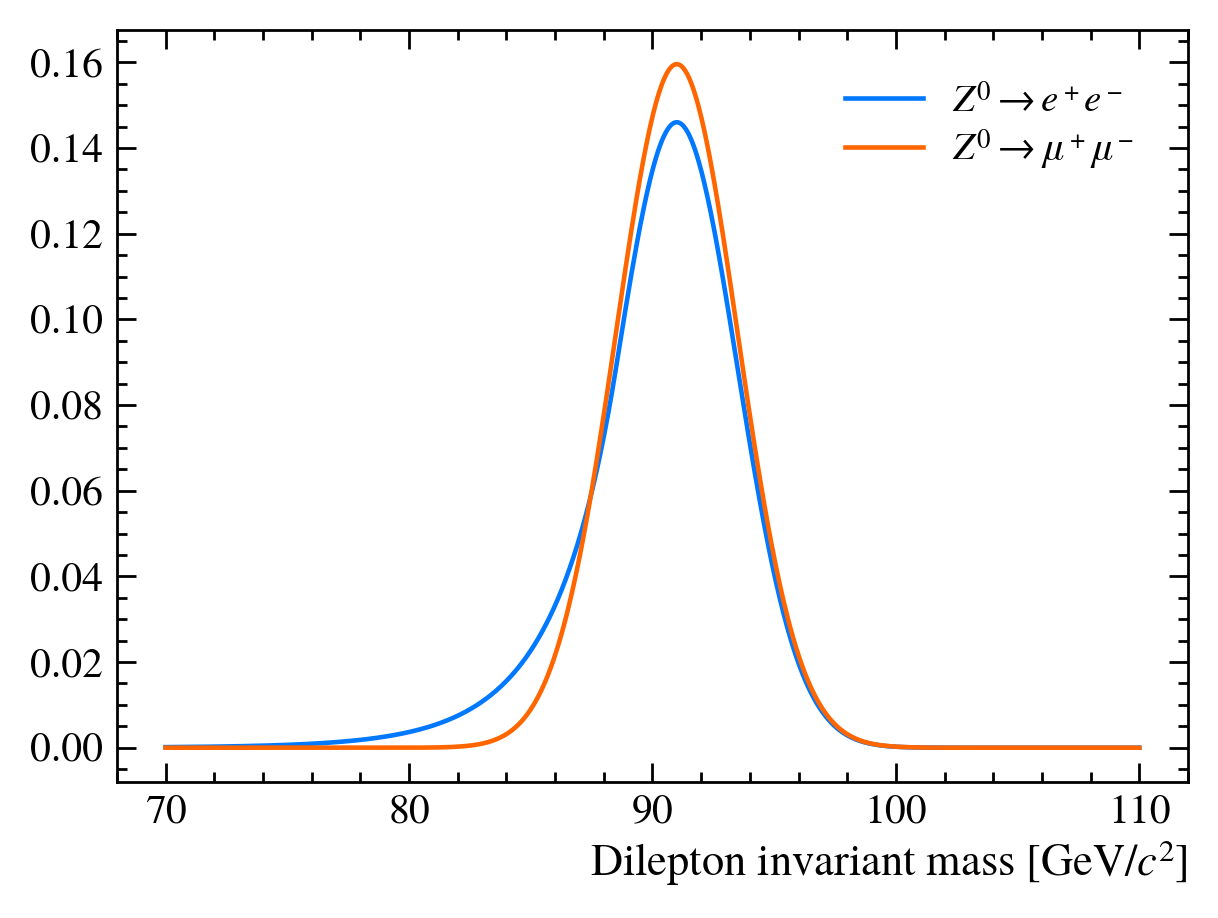

In [15]:
Zmass.set_value(true_Zmass)
Zwidth.set_value(true_Zwidth)

alpha = zfit.Parameter('alpha', 1, floating=False)
n = zfit.Parameter('n', 25, floating=False)
mass_electrons = zfit.pdf.CrystalBall(Zmass, Zwidth, alpha, n, mass)

x = np.linspace(70,110,1000)
plt.plot(x, mass_electrons.pdf(x), label=r"$Z^0\to e^+e^-$")
plt.plot(x, mass_distribution.pdf(x), label=r"$Z^0\to \mu^+\mu^-$")
plt.xlabel(r'Dilepton invariant mass [GeV/$c^2$]')
plt.legend()

Let's repeat the pull study in this case where the true distribution is the skewed Gaussian and we try to estimate the mass by fitting the normal Gaussian.

In [16]:
n_toys = 100
results = {
    'Zmass' : np.zeros(n_toys)*np.nan,
    'Zmass_err' : np.zeros(n_toys)*np.nan,
    'Zwidth' : np.zeros(n_toys)*np.nan,
    'Zwidth_err' : np.zeros(n_toys)*np.nan
}
Zmass.set_value(true_Zmass)
Zwidth.set_value(true_Zwidth)

toydata = mass_electrons.create_sampler(n=n_data) # This is the only line that changed wrt. to the other example!!
nll = zfit.loss.UnbinnedNLL(model=mass_distribution, data=toydata)

for i in range(0,n_toys):
    if i%int(n_toys/10)==0: print(f"{i}/{n_toys}")
    toydata.resample() # create a new random toy data set from the true distribution
    result = minimizer.minimize(nll) # fit the Gauss to the new toy
    result.hesse() # calculate the errors

    # save the values and errors
    results['Zmass'][i] = result.params[Zmass]['value']
    results['Zmass_err'][i] = result.params[Zmass]['hesse']['error']
    results['Zwidth'][i] = result.params[Zwidth]['value']
    results['Zwidth_err'][i] = result.params[Zwidth]['hesse']['error']

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


In [17]:
pull_Zmass = (results['Zmass'] - true_Zmass) / results['Zmass_err']
# Create a pdf for the pulls
mu_pulls = zfit.Parameter('mu_pull', 0, -10, 10)
sig_pulls = zfit.Parameter('sig_pull', 1, 0, 20)
pulls = zfit.Space('pulls', (-20, 20))
gauss_pulls = zfit.pdf.Gauss(mu_pulls, sig_pulls, pulls)

# Create the nll for the fit to the pulls of the Zmass parameter
nll_pull_Zmass = zfit.loss.UnbinnedNLL(model=gauss_pulls, data=pull_Zmass)
fit_pull_Zmass = minimizer.minimize(nll_pull_Zmass)
fit_pull_Zmass.hesse()
print(fit_pull_Zmass)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu_pull, sig_pull]] data=[<zfit.Data: Data obs=('pulls',) shape=(100, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.9e-06 │           148.17 |  8200.071 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name        value  (rounded)        hesse    at limit
--------  ------------------  -----------  ----------
mu_pull             -5.99927  +/-    0.11       False
sig_pull             1.06502  +/-   0.075       False


Maybe as you expected, this is not a normal distribution.

The mean is at -6. This means that the estimate for the $Z^0$ mass is biased and on average, we underestimate it by 6 times the uncertainty.

The width is coincidentally compatible with one.

The residuals can help us here to find out where the model is wrong:

/work/submit/anbeck/miniforge3/envs/tutorialsIAP/lib/python3.12/site-packages/zfit/core/binnedpdf.py:329: UserWarning: Flow currently not fully supported. Values outside the edges are all 0.
  binindices = unbinned_to_binindex(x, self.space, flow=True)


(-5.0, 5.0)

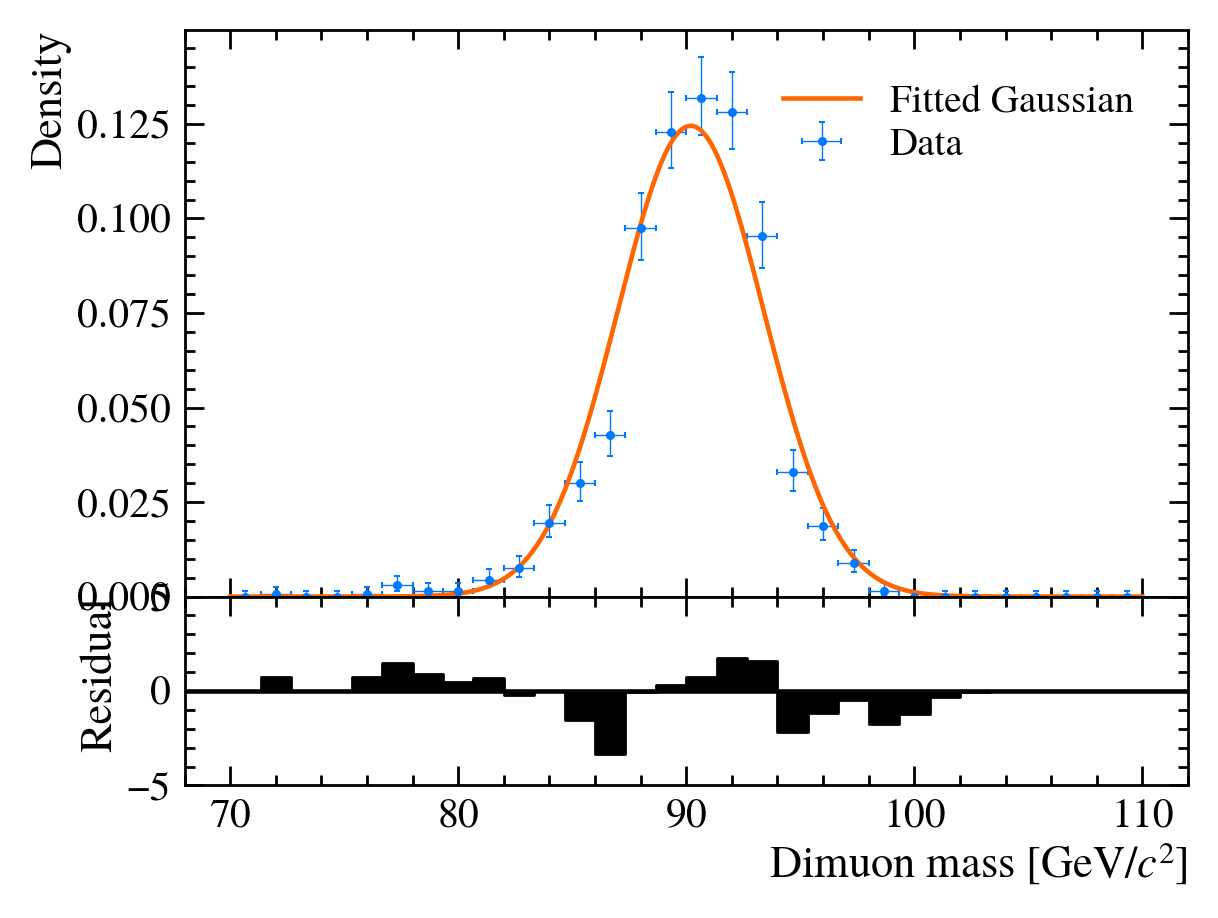

In [18]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace':0}, sharex=True)
# Histogram with the data
H = hist.Hist(hist.axis.Regular(30, 70, 110))
H.fill(toydata["mass"])
mplhep.histplot(H, histtype="errorbar", xerr=True, density=True, label='Data', ax=a0) # Normalize histogram because this is a pdf
x = np.linspace(70,110,1000)
y = mass_distribution.pdf(x).numpy()
a0.plot(x,y,label='Fitted Gaussian')
a0.set_ylim(0,)
a0.set_ylabel('Density')
a0.legend()

"""Calculate residuals for diagnostics"""
plot_residuals(H, mass_distribution, a1)
a1.axhline(y=0, color='k')
a1.set_xlabel(r'Dimuon mass [GeV/$c^2$]')
a1.set_ylabel(r'Residual')
a1.set_ylim(-5,5)

## Simplifications for very large data sets

The amount of time (and computation ressources) a fit needs scales with the amount of data in the sample. In order to speed up the calculations, it can be useful to perform a "binned" fit. Previously, we fitted the distribution to the full data set. In a binned fit, we fit the distribution to a histogram. This means that each histogram bin with its uncertainty is now considered a data point and instead of using millions of data points, the binned fit only ever sees as many data points as the number of bins in the histogram.

**Mind:** when performing a binned fit, there is always a loss of information. There needs to be enough data and you need to ensure that you are choosing a suitable binning.

Let's consider the $Z^0$ mass example with 200M instead of 200 data points.

In [19]:
n_data = 200e6
n_bins = 100

Zmass.set_value(true_Zmass)
Zwidth.set_value(true_Zwidth)
data_unbinned = mass_distribution.sample(n=n_data)

# Binned data and model
binning = zfit.binned.RegularBinning(n_bins, 70, 110, name="mass")
mass_binned = zfit.Space("mass", binning=binning)
data_binned = data_unbinned.to_binned(mass_binned)
model_binned = mass_distribution.to_binned(mass_binned)

Text(0, 1, 'Density')

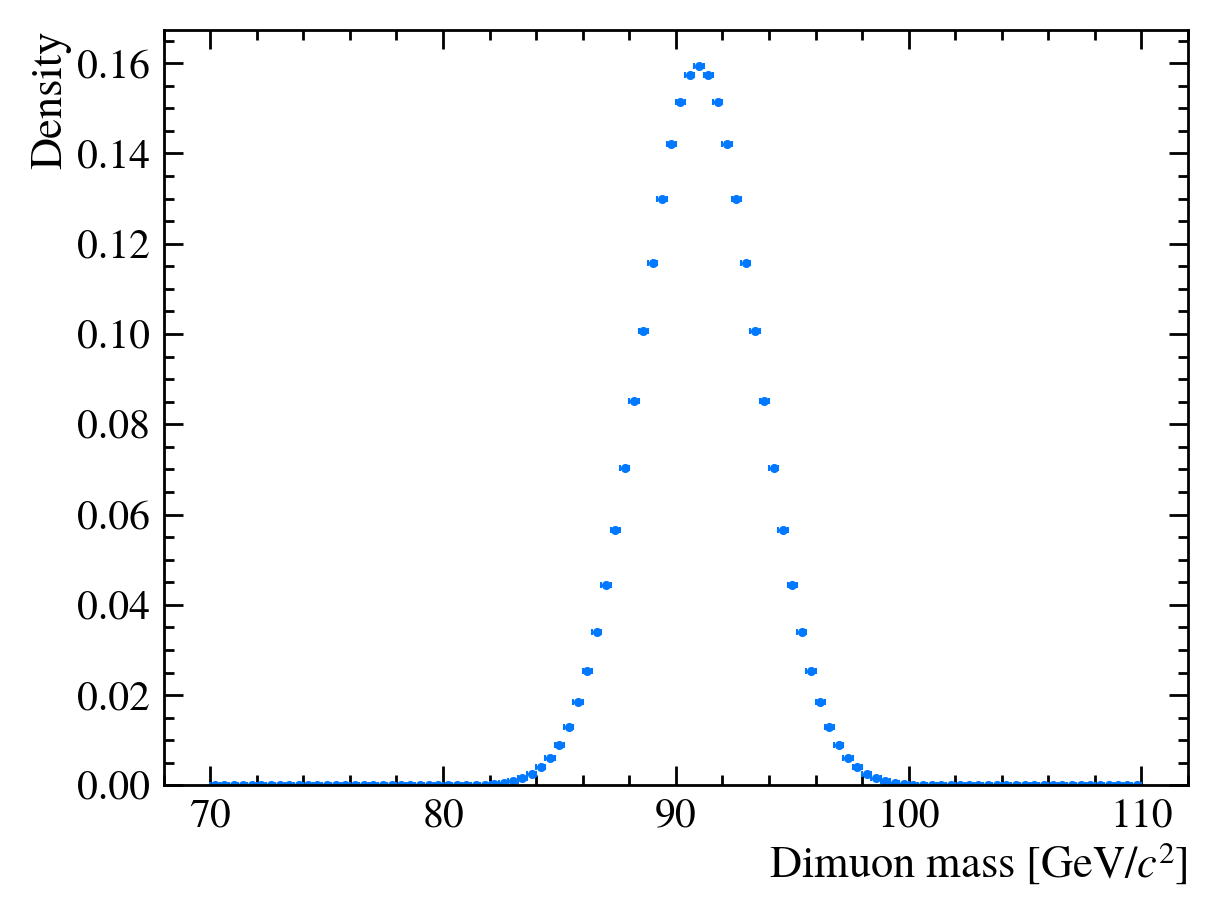

In [20]:
mplhep.histplot(data_binned, histtype="errorbar", xerr=True, density=True)
plt.ylim(0,)
plt.xlabel(r'Dimuon mass [GeV/$c^2$]')
plt.ylabel('Density')

In [21]:
nll_unbinned = zfit.loss.UnbinnedNLL(model=mass_distribution, data=data)
nll_binned = zfit.loss.BinnedNLL(model=model_binned, data=data_binned)

In [22]:
result_unbinned = minimizer.minimize(nll_unbinned)
result_unbinned.hesse()
print(result_unbinned)
result_binned = minimizer.minimize(nll_binned)
result_binned.hesse()
print(result_binned)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[Zmass, Zwidth]] data=[<zfit.Data: Data obs=('mass',) shape=(1000, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.8e-06 │          2323.69 |  9999.655 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
Zmass              91.0516  +/-   0.078       False
Zwidth             2.47121  +/-   0.055       False
FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fab1c5e7fb0>] data=[<zfit._data.binneddatav1.BinnedData o

The results are compatible within their uncertainties! That's because there is a lot of data and we chose a sensible binning.

## Extended pdfs
So far, we were only interested in the shape of the distribution. All functions were normalized to an integral of one (that's why we used "density=True" in the histograms). Very often however, we are interested in the amount of data. In particular when the data has more than one species, for example signal and background. In this case, we work with extended pdfs. This means pdfs that are scaled with the number of data points.

In [23]:
Zmass.set_value(true_Zmass)
Zwidth.set_value(true_Zwidth)

n_signal = 100
N_Z = zfit.Parameter('N_Z', n_signal, 0, 5*n_signal)
mass_distribution = mass_distribution.create_extended(N_Z)

In [24]:
n_bkg = 100
c = zfit.Parameter('c', -0.001, -0.01, 1)
bkg_distribution = zfit.pdf.Exponential(obs=mass, lam=c)
N_bkg = zfit.Parameter('N_bkg', n_bkg, 0, 5*n_bkg)
bkg_distribution = bkg_distribution.create_extended(N_bkg)

In [25]:
full_pdf = zfit.pdf.SumPDF([mass_distribution, bkg_distribution])

2025-01-09 19:38:05.024398: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Text(0, 1, 'Dimuon pairs / 2.00 GeV/$c^2$')

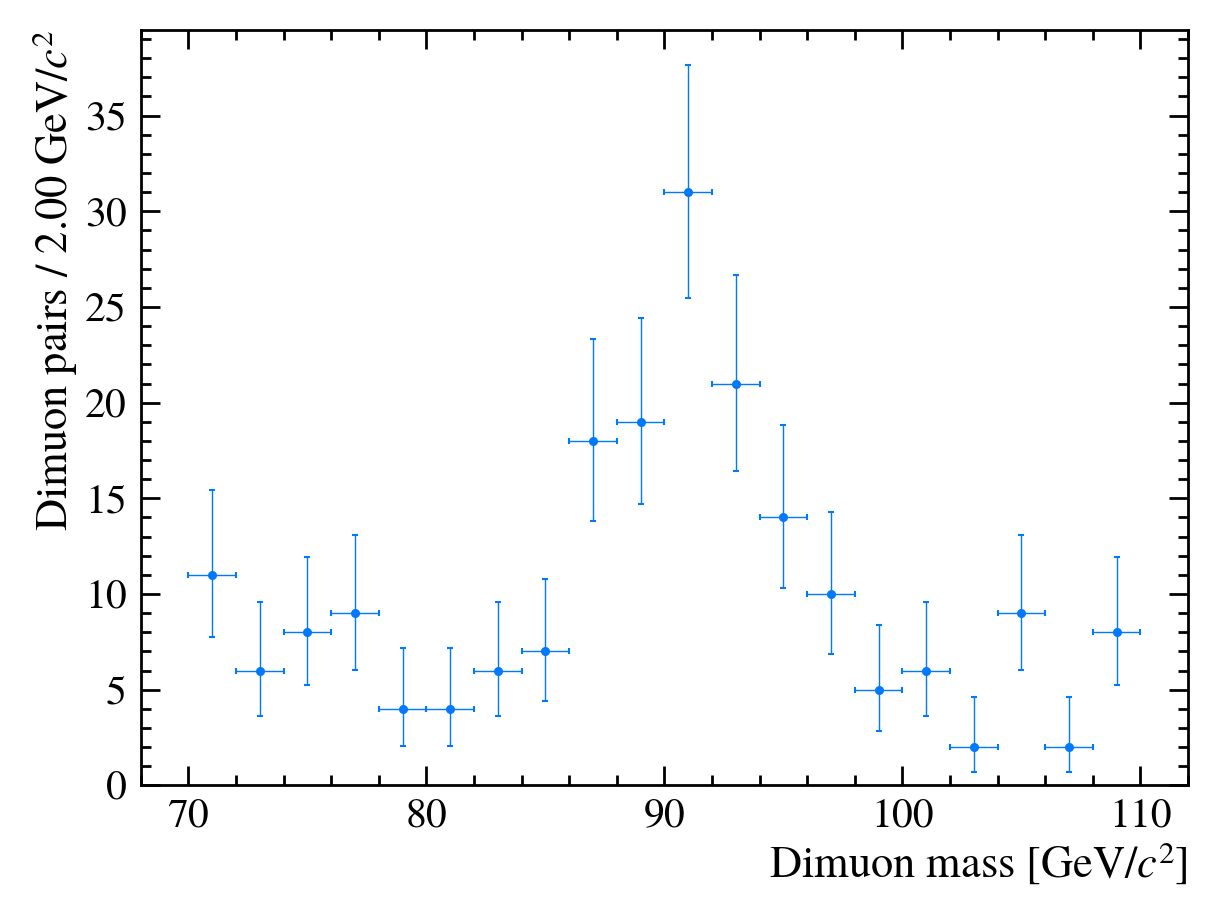

In [26]:
data = full_pdf.sample(n=n_bkg+n_signal)

# A histogram of the pulls for the mean
H = hist.Hist(hist.axis.Regular(20, 70, 110))
H.fill(data['mass'])
mplhep.histplot(H, histtype="errorbar", xerr=True)
plt.ylim(0,)
plt.xlabel(r'Dimuon mass [GeV/$c^2$]')
plt.ylabel(rf'Dimuon pairs / {(110-70)/20:.2f} GeV/$c^2$')

In [27]:
# The NLL needs to be extended, this adds an additional term because the normalisation is not a normal parameter
nll_unbinned = zfit.loss.ExtendedUnbinnedNLL(model=full_pdf, data=data)
result = minimizer.minimize(nll_unbinned)
result.hesse()

{<zfit.Parameter 'N_Z' floating=True value=78.9>: {'error': 12.476505795880035,
  'cl': 0.68268949},
 <zfit.Parameter 'N_bkg' floating=True value=121.1>: {'error': 14.062103448104587,
  'cl': 0.68268949},
 <zfit.Parameter 'Zmass' floating=True value=91.09>: {'error': 0.47143406729042586,
  'cl': 0.68268949},
 <zfit.Parameter 'Zwidth' floating=True value=2.896>: {'error': 0.42220283849648665,
  'cl': 0.68268949},
 <zfit.Parameter 'c' floating=True value=-0.01>: {'error': 0.00020109959392939635,
  'cl': 0.68268949}}

# Exercise
Take the model with signal and background.
1. Run the fit with more or less data.
2. Set up a binned fit for this scenario. What's the minimum amount of bins you need and the minimum amount of data per bin so that you get the same result as for the unbinned fit?
3. Run a toy study for this model (you choose the number of data points and bins and whether you want to do an unbinned or binned fit). Are the parameters unbiased and the uncertainty correct?

